# ID Bound

In [25]:
!pip install ultralytics

In [26]:
import torch.nn as nn

class RotationRegressor(nn.Module):
    def __init__(self, backbone_name="mobilenet_v3_small", pretrained=True):
        super().__init__()
        backbones = {
            "mobilenet_v3_small": (models.mobilenet_v3_small(pretrained=pretrained), 576),
        }
        if backbone_name not in backbones:
            raise ValueError(f"Unknown backbone: {backbone_name}")
        backbone, feature_dim = backbones[backbone_name]
        backbone.classifier = nn.Identity()
        self.backbone = backbone
        self.head = nn.Sequential(nn.Linear(feature_dim, 128), nn.ReLU(), nn.Dropout(0.1), nn.Linear(128,2))
        
    def forward(self, x):
        return F.normalize(self.head(self.backbone(x)), dim=1)

In [27]:
import os
import torch
from PIL import Image
import cv2
from ultralytics import YOLO
import numpy as np
from torchvision import models
from torchvision import transforms
import torch.nn.functional as F
import albumentations as A
from albumentations.pytorch import ToTensorV2


device = "cuda" if torch.cuda.is_available() else "cpu"

id_model_path = '/kaggle/input/id-bound-model/id_detection_best.pt'
id_model = YOLO(id_model_path)

rotation_model = RotationRegressor(backbone_name="mobilenet_v3_small").to(device)
rotation_checkpoint = "/kaggle/input/rotation-correction-model/RotationCorrection.pth"
rotation_model.load_state_dict(torch.load(rotation_checkpoint, map_location=device), strict=False)
rotation_model.eval()

lines_model_path = '/kaggle/input/id-lines-detection/best.pt'
lines_model = YOLO(lines_model_path)


In [28]:
def crop_bbox(image: np.ndarray, bbox: list):
    x1, y1, x2, y2 = map(int, bbox)
    return image[y1:y2, x1:x2]


In [29]:
def correct_rotation(image: np.ndarray):

    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    transform = valid_transform
    img_tensor = transform(image=img)["image"].unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = rotation_model(img_tensor)  
        sin_val, cos_val = output[0]
        angle = np.degrees(np.arctan2(sin_val.item(), cos_val.item())) % 360

    corrected_angle = (angle) % 360

    h, w = image.shape[:2]
    M = cv2.getRotationMatrix2D((w//2, h//2), -corrected_angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE)
    
    return rotated, corrected_angle


In [34]:
def detect_lines(image: np.ndarray):

    results = lines_model(image)
    line_segments = []

    for r in results:  
        for box in r.boxes.xyxy.cpu().numpy():
            x1, y1, x2, y2 = map(int, box)
            line_segments.append(image[y1:y2, x1:x2])
    
    return line_segments



def process_id_images_from_folder(folder_path, num_images=None, id_conf=0.5):
    all_images = [os.path.join(folder_path, f) 
                  for f in os.listdir(folder_path) 
                  if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    if num_images is not None:
        all_images = all_images[:num_images]

    results_list = []

    for image_path in all_images:
        image = cv2.imread(image_path)
        if image is None:
            print(f"Failed to load image: {image_path}")
            results_list.append(None)
            continue

        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = id_model(image_rgb, conf=id_conf) 

        if len(results[0].boxes) == 0:
            print(f"No ID detected in: {image_path}")
            results_list.append(None)
            continue

        bbox = results[0].boxes.xyxy[0].cpu().numpy()
        cropped_id = crop_bbox(image, bbox)
        corrected_id, angle = correct_rotation(cropped_id)
        lines = detect_lines(corrected_id)  

        results_list.append({
            "image_path": image_path,
            "cropped_id": corrected_id,
            "rotation_angle": angle,
            "lines": lines
        })

    return results_list


In [35]:

valid_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])


0: 640x640 1 ID, 185.9ms
Speed: 2.5ms preprocess, 185.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 448x640 (no detections), 112.9ms
Speed: 3.1ms preprocess, 112.9ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)

0: 640x640 1 ID, 173.1ms
Speed: 2.5ms preprocess, 173.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 182.2ms
Speed: 2.8ms preprocess, 182.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 IDs, 186.9ms
Speed: 2.7ms preprocess, 186.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 256x640 (no detections), 93.5ms
Speed: 2.0ms preprocess, 93.5ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 640)

0: 640x640 (no detections), 194.8ms
Speed: 5.7ms preprocess, 194.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
No ID detected in: /kaggle/input/id-bound/test/images/285_jpg.rf.2e8c3cca0b9e0632cd7d8a40

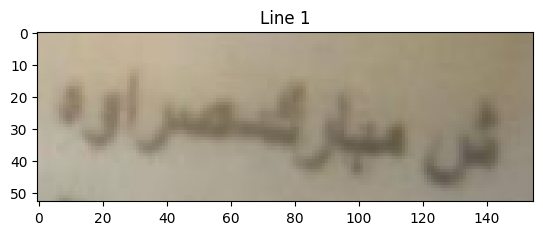

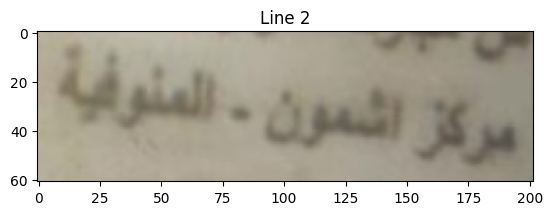

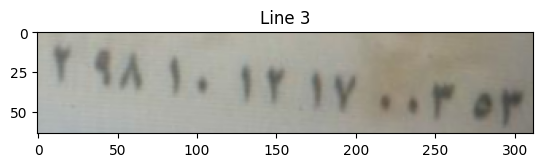

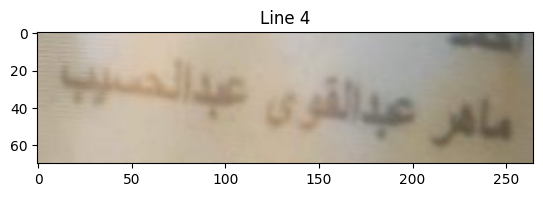

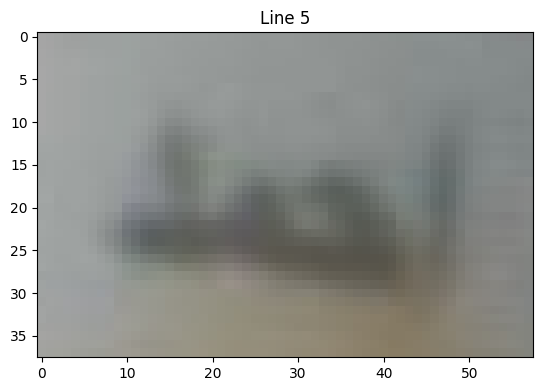

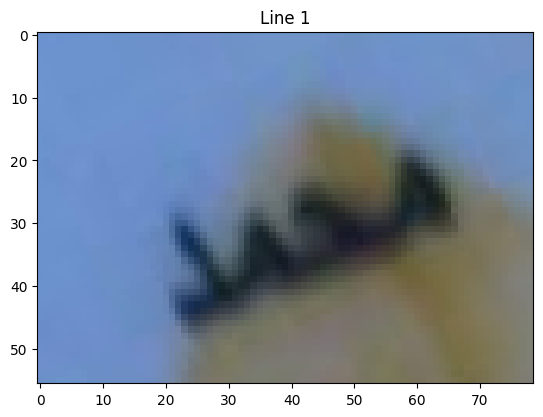

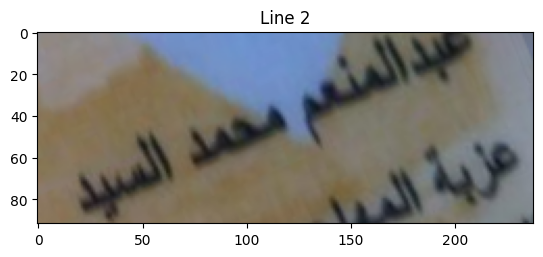

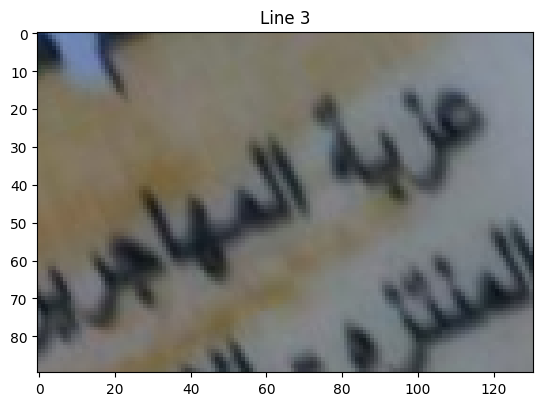

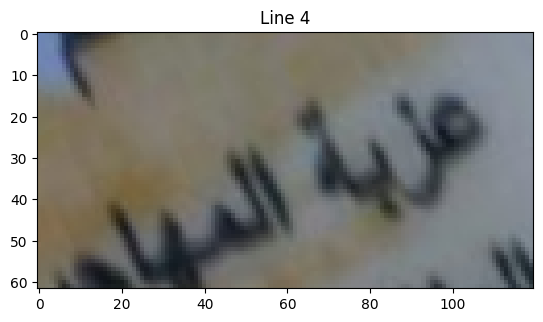

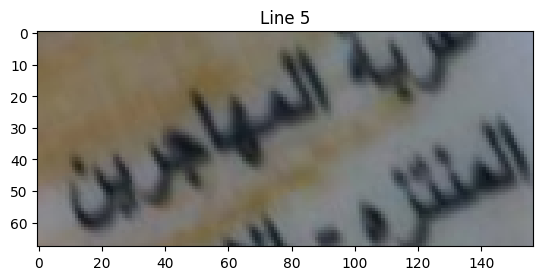

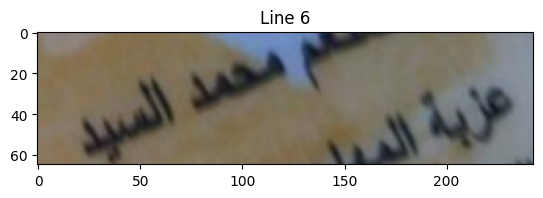

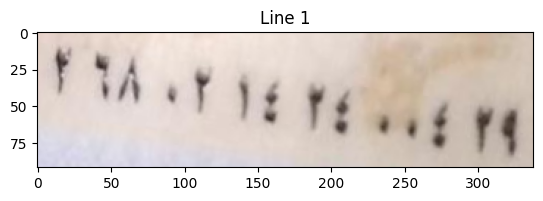

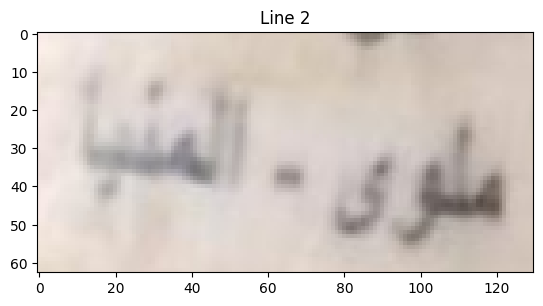

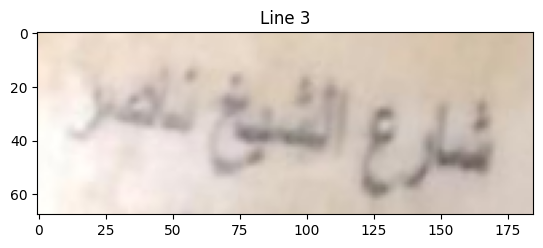

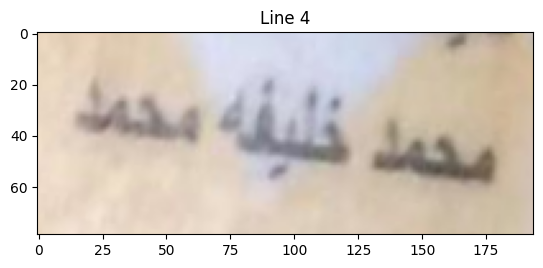

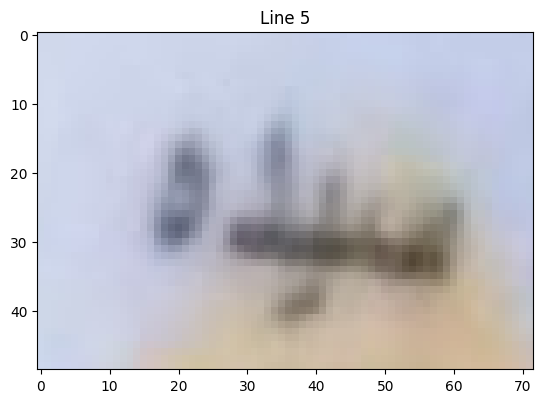

In [36]:

folder = '/kaggle/input/id-bound/test/images'
outputs = process_id_images_from_folder(folder, num_images=15)  

for output in outputs:
    if output is None:
        continue 

    import matplotlib.pyplot as plt
    for i, line in enumerate(output["lines"]):
        plt.imshow(cv2.cvtColor(line, cv2.COLOR_BGR2RGB))
        plt.title(f"Line {i+1}")
        plt.show()
